Always run the below cell first, then each session can stand alone

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as const
from astroquery.simbad import Simbad
from yztools.vhelio2vlsr import vhelio2vlsr_Westmeier

import matplotlib as mpl
mpl.rcParams['font.family'] = 'stixgeneral'

In [2]:
gal_simbad = Simbad.query_object('DDO221') # WLM = DDO221
wlm_dist = 933 # kpc
wlm_coord = SkyCoord(ra=gal_simbad['RA'], dec=gal_simbad['DEC'], 
                     unit=(u.hourangle, u.degree), distance=wlm_dist*u.kpc)
wlm_l = wlm_coord.galactic.l.degree
wlm_b = wlm_coord.galactic.b.degree
wlm_ra = wlm_coord.icrs.ra.degree
wlm_dec = wlm_coord.icrs.dec.degree
wlm_rvir = 89.6*u.kpc # see wlm_mass_eq1n2.ipynb notebook 
print('l = %.4f deg, b = %.4f deg'%(wlm_l, wlm_b))
print('ra = %.4f deg, dec = %.4f deg'%(wlm_ra, wlm_dec))

vhelio = -130
wlm_vlsr = vhelio2vlsr_Westmeier(vhelio, wlm_ra, wlm_dec)
print('vhel = %d km/s, vlsr = %d km/s'%(vhelio, wlm_vlsr))

# for wlm
wlm_rvir_deg = 5.7 # degree
rvir_coord = SkyCoord(ra=(wlm_ra+wlm_rvir_deg)*u.degree, 
                      dec=wlm_dec*u.degree, distance=wlm_dist*u.kpc, frame='icrs')
print('Virial radius(%.1f degree):'%(wlm_rvir_deg), wlm_coord.separation_3d(rvir_coord))

l = 75.8532 deg, b = -73.6258 deg
ra = 0.4912 deg, dec = -15.4639 deg
vhel = -130 km/s, vlsr = -132 km/s
Virial radius(5.7 degree): [89.42132315] kpc


In [3]:
qso_simbad = Simbad.query_object('PHL2525')
qso_coord = SkyCoord(ra=qso_simbad['RA'], dec=qso_simbad['DEC'], unit=(u.hourangle, u.degree))
qso_ra = qso_coord.icrs.ra.degree
qso_dec = qso_coord.icrs.dec.degree
print(qso_ra, qso_dec)

[0.10173042] [-12.76327889]


### Get HI4PI velocity maps for this region, including data from cubes E01/E18/D01/D18

These four cubes, E01/E18/D01/D18 can be downloaded from HI4PI website: http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/A+A/594/A116

And the package yzGALFHI can be downloaded on my github: https://github.com/yzhenggit/yzGALFAHI

In [4]:
import astropy.io.fits as fits
from yzGALFAHI.extract_HI21cm import extract_HI21cm
from yzGALFAHI.get_cubeinfo import get_cubeinfo

First, let's piece all four cubes together 

In [5]:
cubefiles = ['../../Databucket/HI4PI_cubes/CAR_E01.fits', 
             '../../Databucket/HI4PI_cubes/CAR_E18.fits', 
             '../../Databucket/HI4PI_cubes/CAR_D01.fits', 
             '../../Databucket/HI4PI_cubes/CAR_D18.fits']

In [6]:
heads = [fits.getheader(ifile) for ifile in cubefiles]
cubes = [fits.getdata(ifile) for ifile in cubefiles]

In [7]:
arr_vlsr = get_cubeinfo(heads[0])[2]
arr_ra = [get_cubeinfo(ihead)[0] for ihead in heads]
arr_dec = [get_cubeinfo(ihead)[1] for ihead in heads]

In [8]:
# arr_ra[0][0, -26] in E01 equals to arr_ra[1][0, 0] in E18
# arr_dec[0][25, 0] in E01 equals arr_dec[2][-1, 0] in D01

ma_ra = np.concatenate([arr_ra[0][0, :-26], arr_ra[1][0, :]])
ma_dec = np.concatenate([arr_dec[2][:, 0], arr_dec[0][26:, 0]])

ind_vlsr = np.all([arr_vlsr>-450, arr_vlsr<-100], axis=0)
ma_vlsr = arr_vlsr[ind_vlsr]

ma_ra_mod = ma_ra.copy()
ma_ra_mod[ma_ra_mod>50] = ma_ra_mod[ma_ra_mod>50]-360

In [9]:
ma_cube = np.zeros((ma_vlsr.size, ma_dec.size, ma_ra.size))

#put in E01
ma_cube[:, ma_dec.size-arr_dec[0][26:, 0].size:, 0:arr_ra[0][0, :-26].size] = cubes[0][ind_vlsr, 26:, :-26]

# E18
ma_cube[:, ma_dec.size-arr_dec[0][26:, 0].size:, arr_ra[0][0, :-26].size:] = cubes[1][ind_vlsr, 26:, :]

# D01
ma_cube[:, 0:ma_dec.size-arr_dec[0][26:, 0].size, 0:arr_ra[0][0, :-26].size] = cubes[2][ind_vlsr, :, :-26]

# D18
ma_cube[:, 0:ma_dec.size-arr_dec[0][26:, 0].size, arr_ra[0][0, :-26].size:] = cubes[3][ind_vlsr, :, :]

NHI column density map 

In [10]:
vmin = -250 # -250
vmax = -120 # -120
int_range = np.all([ma_vlsr>vmin, ma_vlsr<vmax], axis=0)
vstep = np.abs(np.mean(ma_vlsr[1:]-ma_vlsr[:-1]))
int_NHI = np.sum(ma_cube[int_range]*vstep, axis=0)*1.823e18 
sig_NHI = 0.053*np.sqrt(np.abs(vmin-vmax))*1.823e18
print(np.log10(sig_NHI), sig_NHI)
ind_nsig = int_NHI<2*sig_NHI
# int_NHI[ind_nsig] = np.nan

18.042034214409185 1.101626093976536e+18


In [11]:
fs = 24

In [12]:
# get GBT pointing location 
files = ['data/GBT/GBT_PHL2525_1.txt', 'data/GBT/GBT_PHL2525_2.txt', 'data/GBT/GBT_PHL2525_3.txt', 
         'data/GBT/GBT_PHL2525_4.txt', 'data/GBT/GBT_PHL2525_5.txt', 'data/GBT/GBT_PHL2525_6.txt', 
         'data/GBT/GBT_PHL2525_7.txt', 'data/GBT/GBT_PHL2525_8.txt', 'data/GBT/GBT_PHL2525_9.txt',
         'data/GBT/GBT_PHL2525_10.txt', 'data/GBT/GBT_PHL2525_11.txt', 'data/GBT/GBT_PHL2525_12.txt',
         'data/GBT/GBT_PHL2525_13.txt']
# get coordinates and spectrum  
all_ra = np.zeros(len(files))
all_dec = np.zeros(len(files))
for i, ifile in enumerate(files):
    # coordinates 
    f = open(ifile)
    for line in f:
        if line[0] == 'c': break
    f.close()

    aline = line.replace('\n', '')
    glon = np.float(aline.split(' ')[-2])
    glat = np.float(aline.split(' ')[-1])

    coord = SkyCoord(glon, glat, frame='galactic', unit=(u.deg, u.deg))
    all_ra[i] = coord.icrs.ra.deg
    all_dec[i] = coord.icrs.dec.deg
all_ra[all_ra>10] = all_ra[all_ra>10]-360

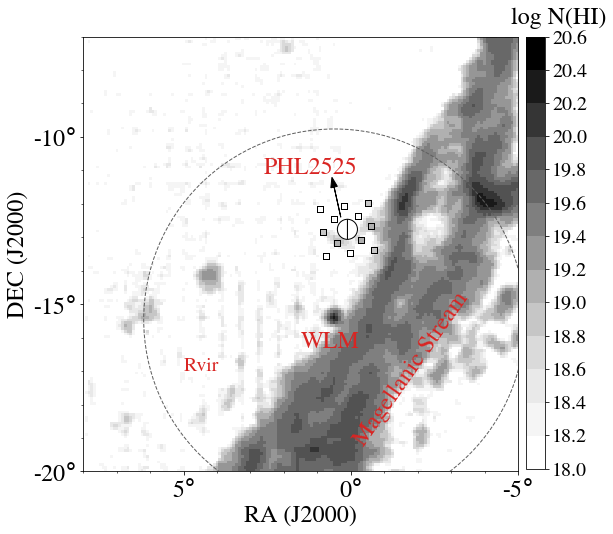

In [14]:
fig = plt.figure(figsize=(9, 8))
ax = fig.add_subplot(111, aspect=1)

# add rvir
cir_1rvir = plt.Circle((wlm_ra, wlm_dec), wlm_rvir_deg*1, facecolor='none', 
                        edgecolor=plt.cm.Greys(.7), linestyle='--')
ax.add_artist(cir_1rvir)
    
# add the NHI map
from yztools.yz_colormap import discrete_map
cmap, val2color, norm, bounds = discrete_map(plt.cm.Greys, 18.0, 20.6, 14)
im = ax.imshow(np.log10(int_NHI), origin='lower', cmap=cmap, norm=norm,interpolation='nearest', 
               extent=[ma_ra_mod.max(), ma_ra_mod.min(), ma_dec.min(), ma_dec.max()])
cax = fig.add_axes([0.86, 0.13, 0.03, 0.75])
cb = fig.colorbar(im, cax=cax, spacing='proportional', format='%.1f', ticks=bounds, boundaries=bounds)
cb.ax.tick_params(labelsize=fs-4)

# add the absorber 
from matplotlib.patches import Wedge
center = [qso_ra[0], qso_dec[0]]
radius = 0.3
w1 = Wedge(center, radius, 90, 270, fc='w', ec='k')
w2 = Wedge(center, radius, 270, 90, fc='w', ec='k')
ax.add_artist(w1)
ax.add_artist(w2)

# add GBT pointing 
nhi = np.array([0, 0, 0, 19, 18.88, 18.86, 0, 19.13, 0, 18.93, 19, 0, 0])
good = nhi>10
ax.scatter(all_ra[good], all_dec[good], marker='s', 
           facecolor=val2color.to_rgba(nhi[good]), edgecolor='k')
bad = nhi<10
ax.scatter(all_ra[bad], all_dec[bad], marker='s', 
           facecolor='none', edgecolor='k')

ax.scatter(all_ra, all_dec, marker='s', edgecolor='k', facecolor='none')

# plotting stuff 
ax.set_xlabel('RA (J2000)', fontsize=24)
ax.set_ylabel('DEC (J2000)', fontsize=24)
ax.set_xticks(np.mgrid[-5:8:5])
ax.set_yticks(np.mgrid[-20:-7:5])
ax.set_xticklabels([r'%d$\degree$'%iv for iv in np.mgrid[-5:8:5]], fontsize=fs)
ax.set_yticklabels([r'%d$\degree$'%iv for iv in np.mgrid[-20:-7:5]], fontsize=fs)
ax.set_xlim(8, -5)
ax.set_ylim(-20, -7)

ax.text(-4.8, -6.6, 'log N(HI)', fontsize=fs)
ax.text(1.5, -16.3, 'WLM', fontsize=fs, color=plt.cm.Reds(0.7))
ax.text(0, -15, 'Magellanic Stream', fontsize=fs, color=plt.cm.Reds(0.7), rotation=55)
ax.text(2.6, -11.1, 'PHL2525', fontsize=fs, color=plt.cm.Reds(0.7))
ax.arrow(0.3, -12.4, 0.2, 0.9, head_width=0.2, color='k')
ax.text(5, -17, 'Rvir', color=plt.cm.Reds(0.7), fontsize=fs-4)

ax.minorticks_on()
# fig.tight_layout()
fig.savefig('figs/wlm_hi4pi_nhi.pdf')

Velocity map 

In [15]:
int_range = np.all([ma_vlsr>vmin, ma_vlsr<vmax], axis=0)
vtrim = ma_vlsr[int_range]
v_top = np.sum(ma_cube[int_range, :, :]*vtrim.reshape((vtrim.size, 1, 1)), axis=0)
v_bot = np.sum(ma_cube[int_range, :, :], axis=0)
vcent = v_top/v_bot
vcent[np.any([vcent<vmin, vcent>vmax], axis=0)] = np.nan


int_range = np.all([ma_vlsr>vmin, ma_vlsr<vmax], axis=0)
vstep = np.abs(np.mean(ma_vlsr[1:]-ma_vlsr[:-1]))
int_NHI = np.sum(ma_cube[int_range]*vstep, axis=0)*1.823e18 
sig_NHI = 0.053*np.sqrt(np.abs(vmin-vmax))*1.823e18
ind_nsig = int_NHI<2*sig_NHI

vcent[ind_nsig] = np.nan

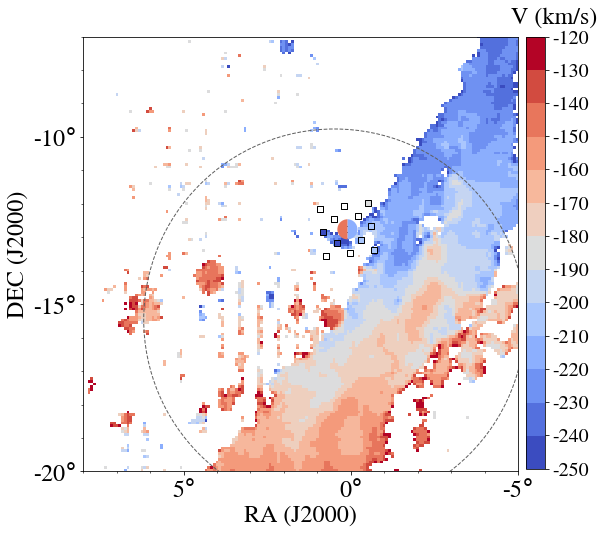

In [17]:
fig = plt.figure(figsize=(9, 8))
ax = fig.add_subplot(111, aspect=1)

# add rvir
cir_1rvir = plt.Circle((wlm_ra, wlm_dec), wlm_rvir_deg*1, facecolor='none', 
                        edgecolor=plt.cm.Greys(.7), linestyle='--')
ax.add_artist(cir_1rvir)
    
# add the NHI map
from yztools.yz_colormap import discrete_map
cmap, val2color, norm, bounds = discrete_map(plt.cm.coolwarm, vmin, vmax, (vmax-vmin)/10.+1)
im = ax.imshow(vcent, origin='lower', cmap=cmap, norm=norm,interpolation='nearest', 
               extent=[ma_ra_mod.max(), ma_ra_mod.min(), ma_dec.min(), ma_dec.max()])
cax = fig.add_axes([0.86, 0.13, 0.03, 0.75])
cb = fig.colorbar(im, cax=cax, spacing='proportional', format='%d', 
                  ticks=bounds, boundaries=bounds)
cb.ax.tick_params(labelsize=fs-4)

# add the absorber 
from matplotlib.patches import Wedge
center = [qso_ra[0], qso_dec[0]]
radius = 0.3
w1 = Wedge(center, radius, 90, 270, fc=val2color.to_rgba(-130-85))
w2 = Wedge(center, radius, 270, 90, fc=val2color.to_rgba(-130-20))
ax.add_artist(w1)
ax.add_artist(w2)

# add GBT pointing 
# add GBT pointing 
pv = np.array([99, 99, 99, -204.7, -210, -189.8, 99, -251.0, 99, -258.3, -203.3, 99, 99])
good = pv<0
ax.scatter(all_ra[good], all_dec[good], marker='s', 
           facecolor=val2color.to_rgba(pv[good]), edgecolor='k')
bad = pv>0
ax.scatter(all_ra[bad], all_dec[bad], marker='s', 
           facecolor='none', edgecolor='k')

# plotting stuff     
ax.set_xlabel('RA (J2000)', fontsize=fs)
ax.set_ylabel('DEC (J2000)', fontsize=fs)
ax.set_xticks(np.mgrid[-5:8:5])
ax.set_yticks(np.mgrid[-20:-7:5])
ax.set_xticklabels([r'%d$\degree$'%iv for iv in np.mgrid[-5:8:5]], fontsize=fs)
ax.set_yticklabels([r'%d$\degree$'%iv for iv in np.mgrid[-20:-7:5]], fontsize=fs)
ax.set_xlim(8, -5)
ax.set_ylim(-20, -7)

ax.text(-4.8, -6.6, 'V (km/s)', fontsize=fs)
#ax.text(1.5, -16.3, 'WLM', fontsize=fs, color=plt.cm.Greys(0.9))
#ax.text(0, -15, 'Magellanic Stream', fontsize=fs, color=plt.cm.Greys(0.9), rotation=55)
#ax.text(3.2, -12.95, 'PHL2525', fontsize=fs, color=plt.cm.Greys(0.9))
#ax.text(5, -17, 'Rvir', color=plt.cm.Greys(.9), fontsize=fs-4)

ax.minorticks_on()
fig.savefig('figs/wlm_hi4pi_vlsr.pdf')

Zoom in to highlight the pointing 

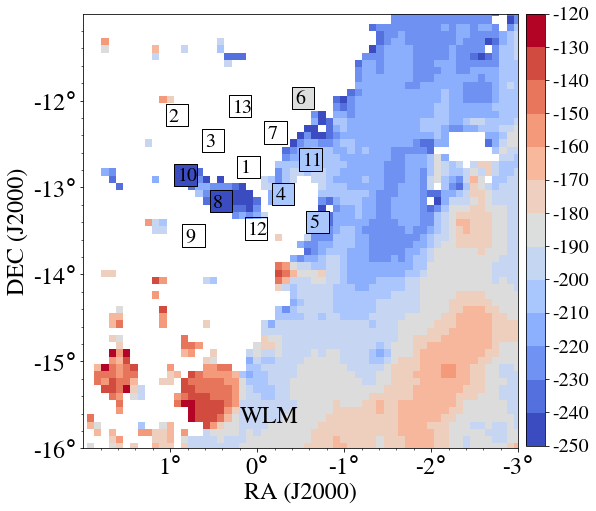

In [18]:
fig = plt.figure(figsize=(9, 8))
ax = fig.add_subplot(111, aspect=1)

# add rvir
cir_1rvir = plt.Circle((wlm_ra, wlm_dec), wlm_rvir_deg*1, facecolor='none', 
                        edgecolor=plt.cm.Greys(.7), linestyle='--')
ax.add_artist(cir_1rvir)
    
# add the NHI map
from yztools.yz_colormap import discrete_map
cmap, val2color, norm, bounds = discrete_map(plt.cm.coolwarm, vmin, vmax, (vmax-vmin)/10.+1)
im = ax.imshow(vcent, origin='lower', cmap=cmap, norm=norm,interpolation='nearest', 
               extent=[ma_ra_mod.max(), ma_ra_mod.min(), ma_dec.min(), ma_dec.max()])
cax = fig.add_axes([0.86, 0.13, 0.03, 0.75])
cb = fig.colorbar(im, cax=cax, spacing='proportional', format='%d', 
                  ticks=bounds, boundaries=bounds)
cb.ax.tick_params(labelsize=fs-4)

# add GBT pointing 
pv = np.array([99, 99, 99, -204.7, -210, -189.8, 99, -251.0, 99, -258.3, -203.3, 99, 99])
good = pv<0
ax.scatter(all_ra[good], all_dec[good], marker='s', s=500,
           facecolor=val2color.to_rgba(pv[good]), edgecolor='k')
bad = pv>0
ax.scatter(all_ra[bad], all_dec[bad], marker='s', s=500,
           facecolor='none', edgecolor='k')
for i in range(len(files)):
    ax.text(all_ra[i]+0.09, all_dec[i]-0.07, files[i].replace('.', '_').split('_')[-2], fontsize=fs-4)

# plotting stuff 
ax.set_xlabel('RA (J2000)', fontsize=24)
ax.set_ylabel('DEC (J2000)', fontsize=24)
ax.set_xticks(np.mgrid[-3:2:1])
ax.set_yticks(np.mgrid[-16:-11:1])
ax.set_xticklabels([r'%d$\degree$'%iv for iv in np.mgrid[-3:2:1]], fontsize=fs)
ax.set_yticklabels([r'%d$\degree$'%iv for iv in np.mgrid[-16:-11:1]], fontsize=fs)
ax.text(0.2, -15.7, 'WLM', fontsize=fs)
ax.set_xlim(2, -3)
ax.set_ylim(-16, -11)

ax.minorticks_on()
# fig.tight_layout()
fig.savefig('figs/wlm_hi4pi_GBT_vlsr.pdf')

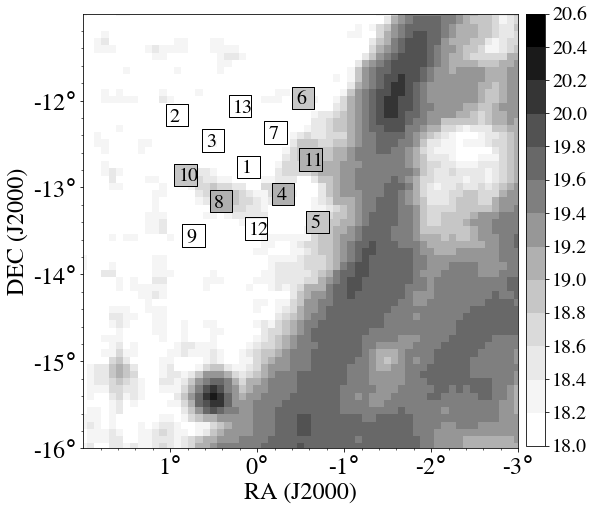

In [19]:
fig = plt.figure(figsize=(9, 8))
ax = fig.add_subplot(111, aspect=1)

# add rvir
cir_1rvir = plt.Circle((wlm_ra, wlm_dec), wlm_rvir_deg*1, facecolor='none', 
                        edgecolor=plt.cm.Greys(.7), linestyle='--')
ax.add_artist(cir_1rvir)
    
# add the NHI map
from yztools.yz_colormap import discrete_map
cmap, val2color, norm, bounds = discrete_map(plt.cm.Greys, 18.0, 20.6, 14)
im = ax.imshow(np.log10(int_NHI), origin='lower', cmap=cmap, norm=norm,interpolation='nearest', 
               extent=[ma_ra_mod.max(), ma_ra_mod.min(), ma_dec.min(), ma_dec.max()])
cax = fig.add_axes([0.86, 0.13, 0.03, 0.75])
cb = fig.colorbar(im, cax=cax, spacing='proportional', format='%.1f', ticks=bounds, boundaries=bounds)
cb.ax.tick_params(labelsize=fs-4)

# add GBT pointing 
nhi = np.array([0, 0, 0, 19, 18.88, 18.86, 0, 19.13, 0, 18.93, 19, 0, 0])
good = nhi>10
ax.scatter(all_ra[good], all_dec[good], marker='s', s=500,
           facecolor=val2color.to_rgba(nhi[good]), edgecolor='k')
bad = nhi<10
ax.scatter(all_ra[bad], all_dec[bad], marker='s', s=500,
           facecolor='none', edgecolor='k')

# ax.scatter(all_ra, all_dec, marker='s', edgecolor='k', facecolor='none')
for i in range(len(files)):
    ax.text(all_ra[i]+0.08, all_dec[i]-0.07, files[i].replace('.', '_').split('_')[-2], fontsize=fs-4)

# add GBT pointing 
#ax.scatter(all_ra, all_dec, marker='o', edgecolor='k', facecolor='none', s=500)
#for i in range(len(files)):
#    ax.text(all_ra[i]+0.08, all_dec[i]-0.07, files[i].replace('.', '_').split('_')[-2], fontsize=fs-4)

# plotting stuff 
ax.set_xlabel('RA (J2000)', fontsize=24)
ax.set_ylabel('DEC (J2000)', fontsize=24)
ax.set_xticks(np.mgrid[-3:2:1])
ax.set_yticks(np.mgrid[-16:-11:1])
ax.set_xticklabels([r'%d$\degree$'%iv for iv in np.mgrid[-3:2:1]], fontsize=fs)
ax.set_yticklabels([r'%d$\degree$'%iv for iv in np.mgrid[-16:-11:1]], fontsize=fs)
ax.set_xlim(2, -3)
ax.set_ylim(-16, -11)

ax.minorticks_on()
# fig.tight_layout()
fig.savefig('figs/wlm_hi4pi_GBT_nhi.pdf')